#Hash Tables

In [1]:
%matplotlib inline
import numpy as np
import random
import string
from matplotlib import pyplot as plt
from IPython.html.widgets import interact
from IPython.html import widgets
from collections import Counter

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
:0: FutureWarning: IPython widgets are experimental and may change in the future.


A *hash table* is a very simple data structure that trades memory space for speed.
Essentially, a hash table is an array or list where items are placed and accessed by a *hash function* rather than by sorting or by order of arrival.
The key advantage of a hash table is speed; most of the operations of a hash table execute very efficiently, independent of its size.
As such, hash tables have very fast lookup times; they form the underlying data structure for Python's set and dictionary types.

The key to an effective hash table is the hash function.
A hash function takes a piece of data as an input and outputs a natural number which corresponds to the index for that piece of data.
Since the hash function must be executed to perform any operation on the hash table (e.g. insertion or lookup), it is imperative that the hash function execute quickly.


The code below demonstrates the principle steps of inserting into a hash table.
In the hash tables in this lab, we will use Python's built-in hash function.

In [2]:
# Make an empty table
capacity = 5
table = [None] * capacity

# Find the hash of 'one'
print hash('one')
print hash('one') % capacity

# Add 'one' to the table
table[hash('one') % capacity] = 'one'
print table

4135046628013640463
3
[None, None, None, 'one', None]


In [3]:
# Add in more strings
table[hash('four') % capacity] = 'four'
table[hash('five') % capacity] = 'five'
print table

['four', None, 'five', 'one', None]


In [4]:
# We can locate 'five' quickly
# Notice that is faster than the list's built-in methods
%timeit table.index('five')

%timeit table[hash('five') % capacity]



The slowest run took 11.17 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 171 ns per loop
10000000 loops, best of 3: 84.5 ns per loop


###Hash Functions

A good hash function will execute quickly and distribute items uniformly throughout the table.

The simplest hash function is using the data itself, reinterpreting it as an integer, then modding by the table capacity.
While simple, if the data is not uniformly distributed then the hashes will not be and more collisions will occur.
For strings, it also causes similar strings like 'HRK19R' and 'RHK19R' to have the same hash.

Below is an example of this simple hash function.
The ord() function returns the value of the character in whatever encoding is being used, this could be ASCII, Unicode, or something else.
Here we use it as a way to uniquely change letters to integers. Then we sum the value of each letter to find the hash for the whole string.

In [5]:
def simple_hash(key, cap):
    # a simple hash for strings with length 6
    tot = 0
    for letter in key:
        tot += ord(letter)
    return tot % cap
        
print simple_hash('HRK19R',19)
print simple_hash('RHK19R',19)

18
18


For strings, a better hash function is shown below.
Multiplying by different large prime numbers in each position prevents similar strings from being hashed to the same value.

In [6]:
def string_hash(key, cap):
    # A hash function for strings with length 6
    h = (ord(key[0]) +
         31 * ord(key[1]) + 
         137 * ord(key[2]) + 
         1571 * ord(key[3]) + 
         11047 * ord(key[4]) + 
         77813 * ord(key[5]))
    return h % cap

print string_hash('HRK19R',19)
print string_hash('RHK19R',19)

8
12


Let's see how well our hash function works using the code below.
Do two strings hash to the same integer?
This is a *hash collision*.
A hash collision is when two unique inputs are mapped to the same index in the hash table.
If not properly handeled, a hash collision can cause us to overwrite older data or not be able to store new data.

In [7]:
# a function to generate random strings
def gen(size=6,chars=string.ascii_uppercase + string.digits):
    return ''.join(random.choice(chars) for _ in range(size))

print 'key\thash'
for i in xrange(5):
    key = gen()
    h = string_hash(key,10)
    print key, '\t', h

key	hash
UVZYYP 	3
Q4NKW7 	8
EVY3UG 	7
JAL2FG 	4
H4II5N 	3


The ideal hash function maps unique inputs to unique outputs that are uniformly distributed over the hash space.
However, it is extremely difficult to create an ideal hash function; most hash functions will experience hash collisions.
Using the code below, explore the relationship between hash collisions and the table capacity.
What do you see?

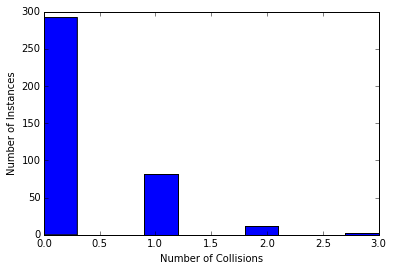

In [8]:
def plot_collisions(num_words,capacity):
    words = []
    hashes = []
    for i in xrange(num_words):
        words.append(gen())
        hashes.append(hash(words[i]) % capacity)
    
    c = Counter(hashes)
    collisions = np.array(c.values())-1
    plt.hist(collisions)
    plt.ylabel('Number of Instances')
    plt.xlabel('Number of Collisions')

    

interact(plot_collisions, 
         num_words=widgets.IntSliderWidget(min=500,max=2000,step=500,value=500),
         capacity=widgets.IntSliderWidget(min=1000,max=4000,step=500,value=1000))

Hash collisions are rare, but become more frequent when our table reaches full capacity.
Thus, whenever our table fills up, we must resize our table to prevent numerous hash collisions.

###Resizing
To resize a hash table, we initialize an array with a larger capacity and then move all the data into it.
This includes rehashing every piece of data.
Choosing a maximum load factor and how big to make the new hash table determines how often we need to resize and depends on the method for resolving collisions.
Typically, we should rehash after our load factor reaches 80% and create a new hash table at least double the size.

In [9]:
capacity = 5
table = [None] * capacity
table[hash('one') % capacity] = 'one'
table[hash('four') % capacity] = 'four'
table[hash('five') % capacity] = 'five'
table[hash('six') % capacity] = 'six'
# Note that our load factor is 4/5.
print table

# When our load factor passes a certain threshold, we need to make the hash table bigger
# Resizing the hash table means rehashing everything in it
def resize(table, new_cap):
    new_table = [None] * new_cap
    for i in table:
        new_table[hash(i) % new_cap] = i
    return new_table
big_table = resize(table, 7)
print big_table


['four', 'six', 'five', 'one', None]
[None, 'six', 'five', None, None, 'one', 'four']


###Dealing with Collisions
Even though hash collisions are rare, we need a way to deal with them so that when they do happen, we don't lose any data.
####Probing
In the first method, we resolve collisions by looking for the next available index.
A short example is below.

In [16]:
capacity = 5
table = [None] * capacity
# Now we add the words 'one' and 'three'
# Notice what happens when we add 'three'
table[hash('six') % capacity] = 'six'
print table
table[hash('three') % capacity] = 'three'
print table

[None, 'six', None, None, None]
[None, 'three', None, None, None]


In [17]:
# We lost the string 'six'
# When we try to retrieve it, we get the string 'three' instead.
print table[hash('six') % capacity]

three


In [18]:
# Start with a new table for this example
capacity = 5
table = [None] * capacity
table[hash('six') % capacity] = 'six'
print table

# We can resolve the collision by looking for the next available index
# Starting at index 1, we look at index 1+1 % capacity, 1+2 % capacity,
    #1+3 % capacity, ..., until we find an empty index
# Seeing that index 2 is None, we store 'three' there
table[2] = 'three'
print table

[None, 'six', None, None, None]
[None, 'six', 'three', None, None]


Now when we are searching for 'three', we hash and find 'six' so we loop through until we find 'three'.

####Chaining
Another method for resolving hash collisions is chaining.
This method slightly alters the structure of our hash table, so that at each index, a list is stored.
When an item is mapped to an index, it is appeneded to the list at that index.

In [19]:
capacity = 5
table = [list() for i in xrange(capacity)]

# Now we add the words 'six' and 'three'
# Notice what happens when we add 'three'
table[hash('six') % capacity].append('six')
print table

table[hash('three') % capacity].append('three')
print table


[[], ['six'], [], [], []]
[[], ['six', 'three'], [], [], []]


For both methods, if the table starts to reach capacity we will be accessing items in linear time rather than constant time, because we have to loop through the table. This completely defeats the purpose of a hash table. For this reason we resize hash tables to keep them sparsely filled. 

####Example
We define our HashTable class by allocating space within a one-dimensional array (in this case, a Python list) using the array size as an argument. This hash table class resolves collisions with probing and resizes when over 80% full.

In [20]:
class HashTable_Probe(object):
    """A Hash Table object. Uses probing (linear) to resolve hash collisions.
    Attributes:
        capacity (int): the maximum number of items in the table.
        size (int): the number of items currently in the hash table.
        table (list): the actual hash table. Each element is a list.
    Notes:
        If the load factor exceeds 0.8, the table's capacity is reset so that
            the load factor drops below 0.2.
    """
    def __init__(self,capacity=4):
        if capacity <= 0: capacity = 1          # No empty tables allowed
        self.table = [None] * capacity          # Initialize list
        self.capacity = capacity
        self._size = 0
    
    def load_factor(self):
        """Return the percent of the hash table that is occupied."""
        return float(self._size)/self.capacity  # Use float division!
    
    def _resize(self,new_capacity):
        """Expand table size and rehash all table elements."""
        data = []
        for i in self.table:
            if i: data.append(i)                # Get all nonempty entries
        self.table = [None] * new_capacity      # New blank table
        self.size = 0                           # Reset the size
        self.capacity = new_capacity            # Reset the capacity
        for i in data:                          # For each nonempy entry,
            self.insert(i)                      # Rehash / reinsert

    
    def insert(self,data):
        """Add a single element to the hash table. Use probing for collisions."""
        index = hash(data) % self.capacity
        while self.table[index]:                # If the list is nonempty at the index,
            if index == self.capacity - 1:           # increment the index until an empty
                index = 0                           # location is found.
            else: index += 1
        self.table[index] = data                # Add data
        self._size += 1                         # Adjust size
        if self.load_factor() > .8 or self._size >= self.capacity:
            self._resize(self.capacity * 4)     # Resize if needed
    
    def __repr__(self):
        """String representation: table contents and load factor."""
        out = str(self.table)
        out += "\nLoad Factor: " + str(self.load_factor())
        return out